# 카메라 스티커앱 - 고양이 수염 스티커 만들기

### 필요한 모듈 임포트

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import os

### 얼굴 사진 가져오기

- 노드에 있는 것처럼 직사각형으로 설정하면 사진이 찌그러져 얼굴영역 인식이 불가능했다.
- 따라서, 원본 사진이 정사각형인 것을 유지하기 위해 640, 640의 크기로 설정하였다.

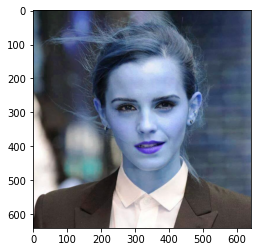

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 640))    # 640x640의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

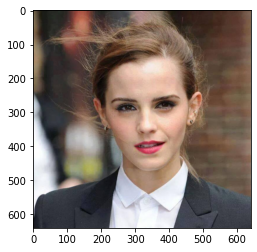

In [3]:
# RGB 이미지로 변경 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

-------------------------------------------

### Face detection

In [4]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

### 얼굴 영역 찾기

rectangles[[(200, 201) (468, 468)]]


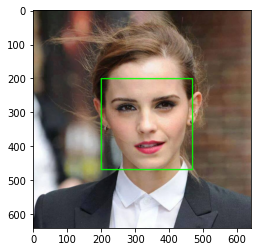

In [5]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

-----------------------------------------------------

### Face landmark

In [6]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [7]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


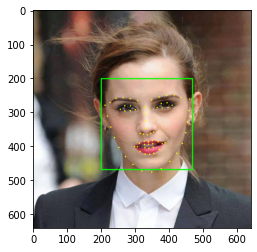

In [8]:
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

-------------------------------------------------------

### 얼굴 중심 좌표(코 중심점) 확인하기

In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # face landmark 인덱스
    x = landmark[33][0]
    y = landmark[51][1] - dlib_rect.width()//2
    w = dlib_rect.width()//2
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(335, 366)
(x,y) : (335,253)
(w,h) : (134,269)


### 고양이 수염 스티커 이미지 resize

In [10]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
print (img_sticker.shape)

(269, 134, 3)


------------------------------------------------

### 원본 사진에 스티커 추가하기 위한 좌표 설정

In [11]:
refined_x = x - w//2  # left
refined_y = y - h # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (268,-16)


In [12]:
img_sticker = img_sticker[-refined_y:] #음수 인덱스 제거
print (img_sticker.shape)

(253, 134, 3)


In [13]:
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(237, 134, 3)
(x,y) : (268,0)


refined_y = 0 #얼굴 사진 경계값으로 수정
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

- 노드에서는 img_sticker==0 인 부분이 검정색을 제외시키도록 하고 있어서, 고양이수염의 검정색 부분을 표시하지 않는 문제가 발생하여, 해당 값을 255(흰색)로 변경하였다.

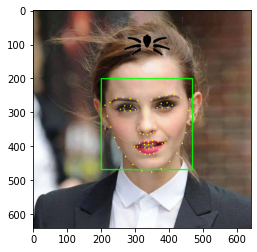

In [14]:
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

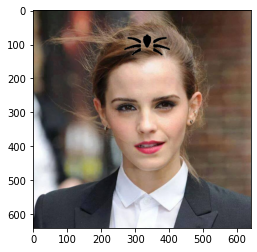

In [15]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # 경계선과 좌표점 제거
plt.show()

--------------------------------------------

## 회고

- 이미지 Resizing을 하는 이유 : 이미지가 너무 크면 속도가 느려지기 때문이다.
- BGR RGB 변환을 사용하는 이유 : openCV는 이미지를 BGR로 나타내고, scikit-image는 이미지를 RGB로 나타낸다.
### 
- 노드의 내용과 달리 변경을 해야했던 부분
- 1. 이미지 리사이징 수치
- 2. 스티커 이미지에서 제외해야 하는 부분(색상값)
- 3. 스티커의 좌표

문제점 및 해결이 필요한 사항
- refine_x 값은 x-w//2로 해야 좌우로 치우치지 않고 코의 중심점에 위치하게 된다.
- 중요한 건 refine_y 값을 조정하는 것인데, 이마까지 내려가나 그 밑으로 내려가지가 않는다.
- 랜드마크 인덱스 값을 조정하여 테스트 해 보면, 이마 위쪽 영역에서만 움직인다.
- 얼굴영역과 랜드마크는 출력된 이미지 상에서 얼굴사진과 일치하나, 수염스티커의 영역이 이들과 일치하지 않는 것으로 보인다.
- 따라서, 정확한 문제 파악을 위해 스티커 위치 조정 원리에 대한 다각적 탐구가 더 필요하다.